In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [7]:
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Conv2D
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import image

Using TensorFlow backend.


In [8]:
LUNGS_DIR = './dataset/final_classification/'

In [9]:
IMG_SHAPE = (256, 256, 3)

In [10]:
base_model = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False

In [11]:
output_channels = base_model.get_output_shape_at(0)[-1]

In [12]:
# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu', name='last_conv')(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax', name='activations')(x)

In [13]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [96]:
train_set = pd.read_csv('./dataset/train_dataset.csv')
train_set.head()

,file,class
0,256341847.jpeg,0
1,923247670.jpeg,0
2,507533737.jpeg,0
3,201920019.jpeg,0
4,505731880.jpeg,0


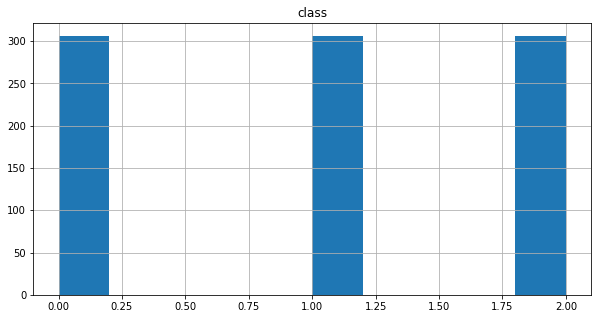

In [97]:
train_set.hist(figsize = (10, 5))
plt.show()

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
IMG_SIZE = (229, 229) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              zoom_range = 0.10)

In [26]:
train_gen = core_idg.flow_from_dataframe(train_set, './dataset/final_classification/', 'file', 'class', batch_size=8)

Found 918 images belonging to 3 classes.


In [27]:
train_x, train_y = next(train_gen)

In [30]:
val_data = pd.read_csv('./dataset/test_dataset.csv')
val_x , val_y = next(
    core_idg.flow_from_dataframe(val_data, './dataset/final_classification/', 'file', 'class', batch_size=90)
)

Found 90 images belonging to 3 classes.


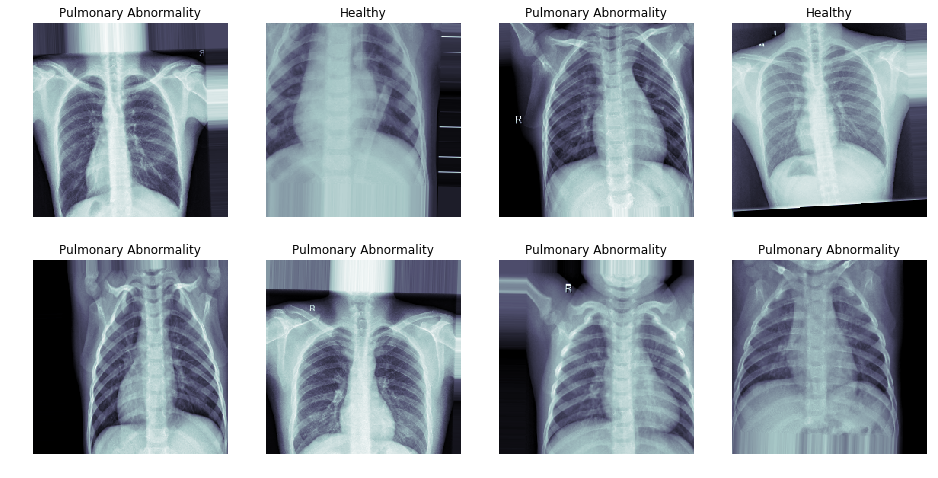

In [31]:
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(train_x, train_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 255)
    c_ax.set_title('%s' % ('Pulmonary Abnormality' if (c_y[1] == 1 or c_y[2] == 1) else 'Healthy'))
    c_ax.axis('off')

In [32]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lungs_clasification')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001
)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [33]:
model.fit_generator(
    train_gen, 
    steps_per_epoch = 20,
    validation_data = (val_x, val_y), 
    epochs = 3, 
    callbacks = callbacks_list
)

Epoch 1/3
20/20 [==============================] - 178s 9s/step - loss: 0.9729 - val_loss: 0.6911

Epoch 00001: val_loss improved from inf to 0.69107, saving model to lungs_clasification_weights.best.hdf5
Epoch 2/3
20/20 [==============================] - 172s 9s/step - loss: 0.7107 - val_loss: 0.4086

Epoch 00002: val_loss improved from 0.69107 to 0.40863, saving model to lungs_clasification_weights.best.hdf5
Epoch 3/3
20/20 [==============================] - 178s 9s/step - loss: 0.5890 - val_loss: 0.3723

Epoch 00003: val_loss improved from 0.40863 to 0.37227, saving model to lungs_clasification_weights.best.hdf5


In [79]:
IMG_SHAPE

(256, 256, 3)

In [80]:
img = cv2.imread(os.path.join(LUNGS_DIR, 'CHNCXR_0373_1.png'))
img = cv2.resize(img, IMG_SHAPE[:2])

In [83]:
img = np.expand_dims(img, axis=0)
#Get the 512 input weights to the softmax.
class_weights = model.layers[-1].get_weights()[0]
#conv_outputs = conv_outputs[0, :, :, :]

In [84]:
final_conv_layer = [layer for layer in model.layers if layer.name == 'last_conv'][0]

In [85]:
get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])

In [86]:
[conv_outputs, predictions] = get_output([img])

In [87]:
predictions

array([[ 0.77676833,  0.02905095,  0.19418067]], dtype=float32)

In [88]:
conv_outputs = conv_outputs[0, :, :, :]

In [89]:
#Create the class activation map.
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[:2])
for i, w in enumerate(class_weights[1, :]):
        cam += w * conv_outputs[:, :, i]

In [90]:
cam /= np.max(cam)
cam = cv2.resize(cam, IMG_SHAPE[:2])
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap[np.where(cam < 0.2)] = 0
img_2 = heatmap*0.5 + img[0]
cv2.imwrite('./abc.jpg', img_2)

True

In [103]:
from utils.batch_generator import BatchGenerator

In [109]:
train_set_custom = pd.read_csv('./dataset/train_dataset.csv')
train_set_custom['image_path'] = train_set_custom.file.apply(lambda x: os.path.join(LUNGS_DIR, x))
train_set_custom['class'] = list(to_categorical(train_set_custom['class']))
train_set_custom.head()

,file,class,image_path
0,256341847.jpeg,"[1.0, 0.0, 0.0]",./dataset/final_classification/256341847.jpeg
1,923247670.jpeg,"[1.0, 0.0, 0.0]",./dataset/final_classification/923247670.jpeg
2,507533737.jpeg,"[1.0, 0.0, 0.0]",./dataset/final_classification/507533737.jpeg
3,201920019.jpeg,"[1.0, 0.0, 0.0]",./dataset/final_classification/201920019.jpeg
4,505731880.jpeg,"[1.0, 0.0, 0.0]",./dataset/final_classification/505731880.jpeg


In [113]:
batch_gen = BatchGenerator(train_set_custom, batch_size = 8, segmentation=False, shape=(256, 256))

In [114]:
train_x, train_y = next(batch_gen.train_batches)

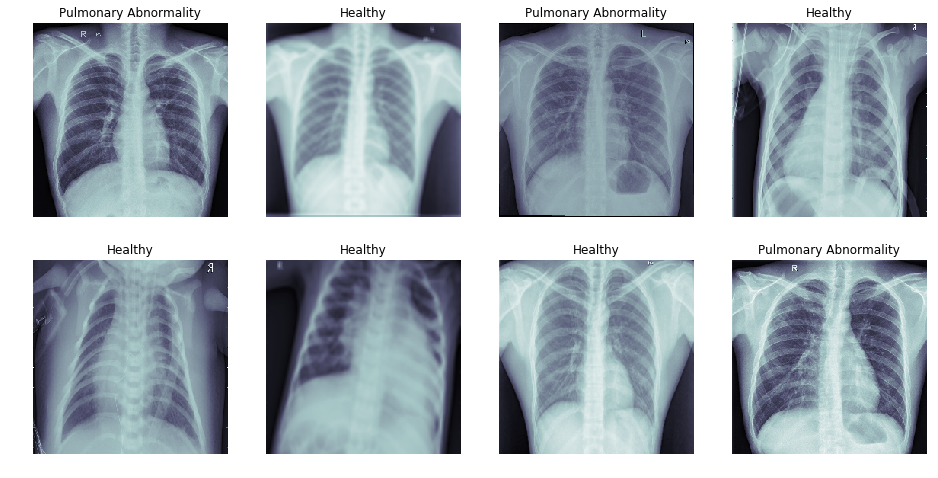

In [115]:
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(train_x, train_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 255)
    c_ax.set_title('%s' % ('Pulmonary Abnormality' if (c_y[1] == 1 or c_y[2] == 1) else 'Healthy'))
    c_ax.axis('off')